<a href="https://colab.research.google.com/github/MaoYingrong/ds-capstone/blob/main/Face_Similarity_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import json
from os import path
import uuid
from PIL import Image

In [ ]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from keras.metrics import Precision, Recall

In [ ]:
#print(tf.__version__)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


# Build the Model

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')
c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [ ]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


# Collect gen_test data

In [ ]:
dataset_path = './testdata_gen'

In [ ]:
n = 0
fir_image = tf.data.Dataset.list_files(os.path.join("testdata_gen",os.listdir("testdata_gen")[0]))
testdataset_gen = tf.data.Dataset.zip((fir_image, fir_image, tf.data.Dataset.from_tensor_slices(tf.ones(1))))

for image in os.listdir("testdata_gen"):
    anchor = tf.data.Dataset.list_files(os.path.join("testdata_gen", image))
    positives = tf.data.Dataset.zip((anchor, anchor, tf.data.Dataset.from_tensor_slices(tf.ones(1))))
    if n == 0:
      negative = tf.data.Dataset.list_files(os.path.join("testdata_gen", image))
      testdataset_gen = testdataset_gen.concatenate(positives)
      n += 1
    elif n == 1:
      negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1))))
      testdataset_gen = testdataset_gen.concatenate(negatives)
      n = 0


In [ ]:
len(testdataset_gen)

225

In [ ]:
x = tf.zeros(1)

In [ ]:
x

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [ ]:
type(x)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
samples = testdataset_gen.as_numpy_iterator()

In [ ]:
for i in range(10):
    print(samples.next())

(b'testdata_gen/Zw180.jpg', b'testdata_gen/Zw180.jpg', 1.0)
(b'testdata_gen/Zw180.jpg', b'testdata_gen/Zw180.jpg', 1.0)
(b'testdata_gen/MC5wbmc.jpg', b'testdata_gen/Zw180.jpg', 0.0)
(b'testdata_gen/Zw215.jpg', b'testdata_gen/Zw215.jpg', 1.0)
(b'testdata_gen/Zw214.jpg', b'testdata_gen/Zw215.jpg', 0.0)
(b'testdata_gen/Zw212.jpg', b'testdata_gen/Zw212.jpg', 1.0)
(b'testdata_gen/Zw213.jpg', b'testdata_gen/Zw212.jpg', 0.0)
(b'testdata_gen/Zw211.jpg', b'testdata_gen/Zw211.jpg', 1.0)
(b'testdata_gen/Zw210.jpg', b'testdata_gen/Zw211.jpg', 0.0)
(b'testdata_gen/Zw209.jpg', b'testdata_gen/Zw209.jpg', 1.0)


In [ ]:
testdataset_gen = testdataset_gen.map(preprocess_twin)
testdataset_gen = testdataset_gen.cache()
testdataset_gen = testdataset_gen.shuffle(buffer_size=10000)
testdataset_gen = testdataset_gen.batch(15)
testdataset_gen = testdataset_gen.prefetch(8)

In [ ]:
%reset_selective -f "^data$"

# Collect LFW Data

In [ ]:
dataset_path = './lfw'

In [ ]:
n = 0
num_positive = 0
num_negative = 0
for directory in os.listdir(dataset_path):
    files = os.listdir(os.path.join(dataset_path,directory))

    try:
      if len(files) == 1:
          if num_negative > 1999:
              pass
          else:
            if n == 0:
                negative1 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
                n += 1
            elif n == 1:
                negative2 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
                negatives = tf.data.Dataset.zip((negative1, negative2, tf.data.Dataset.from_tensor_slices(tf.zeros(1))))
                data_lfw = data_lfw.concatenate(negatives)
                num_negative += 1
                n = 0

      elif len(files) > 1:
          if num_positive > 1999:
            if n == 0:
                negative1 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
                n += 1
            elif n == 1:
                negative2 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
                negatives = tf.data.Dataset.zip((negative1, negative2, tf.data.Dataset.from_tensor_slices(tf.zeros(1))))
                data_lfw = data_lfw.concatenate(negatives)
                num_negative += 1
                n = 0
          else:
            positive1 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
            for i in range(len(files)-1):
              positive_x = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[i+1]))
              positives = tf.data.Dataset.zip((positive1, positive_x, tf.data.Dataset.from_tensor_slices(tf.ones(1))))
              data_lfw = data_lfw.concatenate(positives)
              num_positive += 1

    except:
      print(1)
      if len(files) == 1:
          if n == 0:
              negative1 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
              n += 1
          elif n == 1:
              negative2 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
              data_lfw = tf.data.Dataset.zip((negative1, negative2, tf.data.Dataset.from_tensor_slices(tf.zeros(1))))
              num_negative += 1
              n = 0
      elif len(files) > 1:
            positive1 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[0]))
            positive_2 = tf.data.Dataset.list_files(os.path.join(dataset_path, directory,files[1]))
            data_lfw = tf.data.Dataset.zip((positive1, positive_2, tf.data.Dataset.from_tensor_slices(tf.ones(1))))
            num_positive += 1
    print(num_positive,num_negative)

    

In [ ]:
print("length of data", len(data_lfw))
print(num_positive)
print(num_negative)

length of data 4116
2009
2107


In [ ]:
samples = data_lfw.as_numpy_iterator()

In [ ]:
for i in range(20):
    print(samples.next())

(b'./lfw/Stephen_Friedman/Stephen_Friedman_0001.jpg', b'./lfw/Stephen_Friedman/Stephen_Friedman_0002.jpg', 1.0)
(b'./lfw/Donald_Fehr/Donald_Fehr_0001.jpg', b'./lfw/Donald_Fehr/Donald_Fehr_0002.jpg', 1.0)
(b'./lfw/Donald_Fehr/Donald_Fehr_0001.jpg', b'./lfw/Donald_Fehr/Donald_Fehr_0003.jpg', 1.0)
(b'./lfw/Donald_Fehr/Donald_Fehr_0001.jpg', b'./lfw/Donald_Fehr/Donald_Fehr_0004.jpg', 1.0)
(b'./lfw/Linda_Mason/Linda_Mason_0001.jpg', b'./lfw/Alberto_Sordi/Alberto_Sordi_0001.jpg', 0.0)
(b'./lfw/Alex_Penelas/Alex_Penelas_0001.jpg', b'./lfw/Alex_Penelas/Alex_Penelas_0002.jpg', 1.0)
(b'./lfw/Mark_Heller/Mark_Heller_0001.jpg', b'./lfw/Mark_Heller/Mark_Heller_0002.jpg', 1.0)
(b'./lfw/Stephen_Covey/Stephen_Covey_0001.jpg', b'./lfw/Natalia_Vodonova/Natalia_Vodonova_0001.jpg', 0.0)
(b'./lfw/Oscar_de_la_Renta/Oscar_de_la_Renta_0001.jpg', b'./lfw/Chris_Klein/Chris_Klein_0001.jpg', 0.0)
(b'./lfw/David_Ballantyne/David_Ballantyne_0001.jpg', b'./lfw/Bob_Ferguson/Bob_Ferguson_0001.jpg', 0.0)
(b'./lfw/Gilli

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
data_lfw = data_lfw.map(preprocess_twin)
data_lfw = data_lfw.cache()
data_lfw = data_lfw.shuffle(buffer_size=10000)

In [ ]:
train_data_lfw = data_lfw.take(round(len(data_lfw)*.7))
train_data_lfw = train_data_lfw.batch(16)
train_data_lfw = train_data_lfw.prefetch(8)

In [ ]:
test_data_lfw = data_lfw.skip(round(len(data_lfw)*.7))
test_data_lfw = test_data_lfw.take(round(len(data_lfw)*.3))
test_data_lfw = test_data_lfw.batch(16)
test_data_lfw = test_data_lfw.prefetch(8)

# Similarity Data

## Preprocessing similarity data

In [ ]:
# Preprocess the image
data_path = "./Image"
root22 = "./img_jpg"
root23 = "./all_image_jpg"

In [ ]:
#@title Convert to JPG RGB
'{}.jpg'.format(uuid.uuid1()))


for directory in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path,directory))
    for image in files:
      print(image)
      im = Image.open(os.path.join(data_path, directory,image))
      fill_color = (255,255,255)   # your new background color

      im = im.convert("RGBA")   # it had mode P after DL it from OP
      if im.mode in ('RGBA', 'LA'):
          background = Image.new(im.mode[:-1], im.size, fill_color)
          background.paste(im, im.split()[-1]) # omit transparency
          im = background
      result = image.replace(".png", ".jpg")
      if path.exists(root22+"/"+directory) == False:
        os.mkdir(root22+"/"+directory)

      im.convert("RGB").save(os.path.join(root22, directory,result))


In [ ]:
#@title Put all images into one file
try_number = 0

for directory in os.listdir(root22):
    files = os.listdir(os.path.join(root22,directory))
    for image in files:
      im = Image.open(os.path.join(root22, directory,image))
      result = directory.rstrip("1234567890").replace("gen_", "").replace("long","longg") +'{}.jpg'.format(uuid.uuid1())
      print(result)
      try_number += 1  
      im.save(os.path.join(root23, result))  

In [ ]:
try_number

2909

In [ ]:
num_Male = 0
num_Female = 0
num_Child = 0
num_YoungAdult = 0
num_Adult = 0
num_Eld = 0
num_White = 0
num_Black = 0
num_Latino = 0
num_Asian = 0
num_black_brown = 0
num_blond = 0
num_gray = 0
num_short = 0
num_medium = 0
num_long = 0

In [ ]:
num_try = 0

for name in os.listdir(root23):
  num_try += 1

  name_list = name.split("_")
  print(num_try, name_list)

  if name_list[0] == "M":
    num_Male += 1
  else:
    num_Female += 1

  if name_list[1] == "Chi":
    num_Child += 1
  elif name_list[1] == "You":
    num_YoungAdult += 1
  elif name_list[1] == "Adu":
    num_Adult += 1
  elif name_list[1] == "Eld":
    num_Eld += 1
  
  if name_list[2] == "W":
    num_White += 1
  elif name_list[2] == "B":
    num_Black += 1
  elif name_list[2] == "L":
    num_Latino += 1 
  elif name_list[2] == "A":
    num_Asian += 1
  
  if name_list[3] == "brown" or name_list[3] == "black":
    num_black_brown += 1
  elif name_list[3] == "blond":
    num_blond += 1
  elif name_list[3] == "gray":
    num_gray += 1

  if name_list[4] == "short":
    num_short += 1
  elif name_list[4] == "medium":
    num_medium += 1
  elif name_list[4] == "longg":
    num_long += 1

1 ['M', 'Adu', 'W', 'brown', 'short', '81edf3f8-7bca-11ed-adc0-0242ac1c000c.jpg']
2 ['M', 'Adu', 'W', 'brown', 'short', '8243aafa-7bca-11ed-adc0-0242ac1c000c.jpg']
3 ['M', 'Adu', 'W', 'brown', 'short', '82903c12-7bca-11ed-adc0-0242ac1c000c.jpg']
4 ['M', 'Adu', 'W', 'brown', 'short', '82de8a98-7bca-11ed-adc0-0242ac1c000c.jpg']
5 ['M', 'Adu', 'W', 'brown', 'short', '832c0f3e-7bca-11ed-adc0-0242ac1c000c.jpg']
6 ['M', 'Adu', 'W', 'brown', 'short', '83770a84-7bca-11ed-adc0-0242ac1c000c.jpg']
7 ['M', 'Adu', 'W', 'brown', 'short', '83c5c3b8-7bca-11ed-adc0-0242ac1c000c.jpg']
8 ['M', 'Adu', 'W', 'brown', 'short', '840cf576-7bca-11ed-adc0-0242ac1c000c.jpg']
9 ['M', 'Adu', 'W', 'brown', 'short', '84608a24-7bca-11ed-adc0-0242ac1c000c.jpg']
10 ['M', 'Adu', 'W', 'brown', 'short', '84b153f0-7bca-11ed-adc0-0242ac1c000c.jpg']
11 ['M', 'Adu', 'W', 'brown', 'short', '84fe434a-7bca-11ed-adc0-0242ac1c000c.jpg']
12 ['M', 'Adu', 'W', 'brown', 'short', '85480d90-7bca-11ed-adc0-0242ac1c000c.jpg']
13 ['M', 'Adu

In [ ]:
print("num_Male: ", num_Male,
"\n num_Female: ", num_Female,
"\n num_Child: ", num_Child,
"\n num_YoungAdult: ", num_YoungAdult,
"\n num_Adult: ", num_Adult,
"\n num_Eld: ", num_Eld,
"\n num_White: ", num_White,
"\n num_Black: ", num_Black,
"\n num_Latino: ", num_Latino,
"\n num_Asian: ", num_Asian,
"\n num_black_brown: ", num_black_brown,
"\n num_blond: ", num_blond,
"\n num_gray: ", num_gray,
"\n num_short: ", num_short,
"\n num_medium: ", num_medium,
"\n num_long: ", num_long)

num_Male:  1202 
 num_Female:  1707 
 num_Child:  821 
 num_YoungAdult:  1097 
 num_Adult:  792 
 num_Eld:  199 
 num_White:  1286 
 num_Black:  582 
 num_Latino:  508 
 num_Asian:  533 
 num_black_brown:  2650 
 num_blond:  173 
 num_gray:  86 
 num_short:  1702 
 num_medium:  832 
 num_long:  375


In [ ]:
print("sex: ", num_Male+num_Female)
print("age: ", num_Child+num_YoungAdult+num_Adult+num_Eld)
print("ethnicity: ", num_White+num_Black+num_Latino+num_Asian)
print("hair color: ", num_black_brown +num_blond+num_gray)
print("hair length: ", num_short+num_medium+num_long)

sex:  2909
age:  2909
ethnicity:  2909
hair color:  2909
hair length:  2909


## Collect similarity into tensorflow

In [ ]:
import random

In [ ]:
%reset_selective -f "^data_set1$"

In [ ]:
image_files = os.listdir(root23)
len(image_files)

2909

In [ ]:
num_total = 0
image_files = os.listdir(root23)
random.shuffle(image_files)

n = 0


for image_name1 in image_files[:30]:

    #if num_total > 20:
      #break

    name_list1 = image_name1.split("_")
    similarity = 1


    for image_name2 in image_files[1000:1200]:
      #if num_total > 20:
        #break
      num_total += 1
      print(num_total)
      name_list2 = image_name2.split("_")
      if name_list1[0] != name_list2[0]:
        similarity -=0.2
      if name_list1[1] != name_list2[1]:
        similarity -=0.3        
      if name_list1[2] != name_list2[2]:
        similarity -=0.3        
      if name_list1[3] != name_list2[3]:
        if name_list1[3] not in ["brown","black"] and name_list2[3] not in ["brown","black"]:
          similarity -= 0.1
      if name_list1[4] != name_list2[4]:
        similarity -= 0.1  
      
      pair_01 = tf.data.Dataset.list_files(os.path.join(root23, image_name1))
      pair_02 = tf.data.Dataset.list_files(os.path.join(root23, image_name2))
      similarity = tf.cast(similarity, tf.float32)
      print(image_name1,image_name2,similarity)
      #<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>
      x = tf.convert_to_tensor([[tf.cast(similarity, tf.float32)]])

      pair = tf.data.Dataset.zip((pair_01, pair_02, tf.data.Dataset.from_tensor_slices(x)))
      
      try:
        data_set1 = data_set1.concatenate(pair)
        print(len(data_set1))
      except:
        data_set1 = pair
      similarity = 1


In [ ]:
len(data_set1)

6000

In [ ]:
samples = data_set1.as_numpy_iterator()

In [ ]:
for i in range(20):
    print(samples.next())

In [ ]:
data_2 = data_set1

In [ ]:
data_2 = data_2.map(preprocess_twin)
data_2 = data_2.cache()
data_2 = data_2.shuffle(buffer_size=10000)

In [ ]:
train_data_2 = data_2.take(round(len(data_2)*.7))
train_data_2 = train_data_2.batch(16)
train_data_2 = train_data_2.prefetch(8)

In [ ]:
test_data_2 = data_2.skip(round(len(data_2)*.7))
test_data_2 = test_data_2.take(round(len(data_2)*.3))
test_data_2 = test_data_2.batch(16)
test_data_2 = test_data_2.prefetch(8)

In [ ]:
len(train_data_2)

263

In [ ]:
files_num = 0

for directory in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path,directory))
    print(directory, len(files))
    files_num += len(files)

gen_F_Adu_B_brown_medium_60 60
gen_F_Adu_B_brown_long_60 31
gen_F_Adu_L_brown_long_2 2
gen_F_Adu_W_blond_long_ 6
gen_F_Adu_W_blond_medium_ 25
gen_F_Adu_A_brown_short_ 7
gen_F_Adu_L_brown_short_60 60
gen_F_Adu_B_brown_short_60 60
gen_F_Adu_L_brown_medium_17 17
gen_F_Adu_A_brown_long_4 4
gen_F_Chi_L_brown_medium_19 19
gen_F_Chi_A_brown_long_1 1
gen_F_Chi_A_brown_short_60 60
gen_F_Adu_W_brown_long_ 2
gen_F_Chi_A_brown_medium_60 60
gen_F_Chi_B_brown_medium_3 3
gen_F_Adu_W_brown_short_60 64
gen_F_Adu_W_brown_medium_60 65
gen_F_Chi_B_brown_short_60 60
gen_F_Adu_W_blond_short_60 25
gen_F_Eld_W_brown_short_ 11
gen_F_Chi_W_blond_long_ 18
gen_F_Chi_W_blond_medium_ 46
gen_F_Chi_W_brown_medium_60 61
gen_F_Chi_L_brown_short_60 60
gen_F_Chi_W_brown_short_60 60
gen_F_You_A_brown_long_60 60
gen_F_Eld_W_gray_short_ 6
gen_F_Chi_W_blond_short_ 22
gen_F_Chi_W_brown_long_ 38
gen_F_You_B_brown_short_60 60
gen_F_You_A_brown_short_60 60
gen_F_You_A_brown_medium_60 60
gen_F_You_B_brown_medium_60 60
gen_F_You_W

In [ ]:
samples = test_data.as_numpy_iterator()

# Choose the model

In [ ]:
create_new_model = make_siamese_model()

In [ ]:
# Reload model 
siamese_model_trained = keras.models.load_model('siamesemodel_trained.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Reload mode2
siamese_model_v2 = keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
siamese_model = create_new_model

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Train the Model

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
mean_SquareError = tf.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
def contrastive_loss(logits1, logits2, label, margin, eps=1e-7):
    Dw = tf.sqrt(eps + tf.reduce_sum(tf.square(logits1 - logits2), 1))
    loss = tf.reduce_mean((1. - tf.cast(label,dtype=tf.float32)) * tf.square(Dw) + tf.cast(label,dtype=tf.float32) * tf.math.square(tf.maximum(margin - Dw, 0)))
    return loss, Dw

In [ ]:
if path.exists('./training_checkpoints') == False:
  os.mkdir('./training_checkpoints')

os.chdir('./training_checkpoints')
!pwd
!ls
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

/content/gdrive/MyDrive/Colab Notebooks/training_checkpoints


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
#Original training
@tf.function
def train_step(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
    

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss


In [ ]:
#Original trainning
precision_value = []

def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            #print(batch[2], yhat)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        precision_value.append(p.result().numpy())
        print(precision_value)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
EPOCHS = 50
train(train_data, EPOCHS)

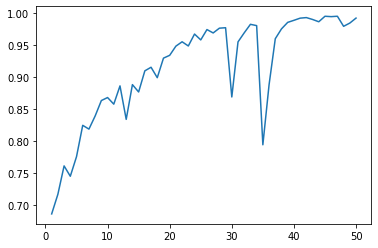

In [ ]:
x = np.arange(1,51)
y = np.array([0.6856474, 0.71636087, 0.76076555, 0.74457306, 0.77522254, 0.8242424, 0.8183242, 0.8388589, 0.8630137, 0.86771303, 0.85735625, 0.88595164, 0.8335756, 0.8879121, 0.8764045, 0.90948904, 0.9150943, 0.8987708, 0.9293598, 0.93377, 0.94813734, 0.95494187, 0.9483871, 0.96703297, 0.95788723, 0.9740549, 0.9687722, 0.9762248, 0.9769452, 0.8686131, 0.95477754, 0.9689485, 0.9822695, 0.980226, 0.793806, 0.8877119, 0.9597122, 0.97514206, 0.98531574, 0.98852223, 0.9919058, 0.9927902, 0.98986244, 0.98625183, 0.9948718, 0.99428165, 0.99489796, 0.9791367, 0.9842294, 0.9920116]
)
plt.plot(x,y)
plt.show()

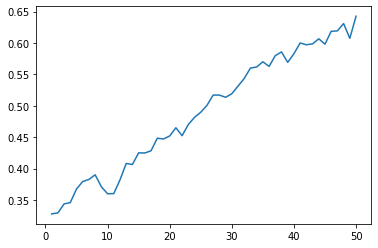

In [ ]:
x = np.arange(1,51)
plt.plot(x,y)
plt.show()

In [ ]:
@tf.function
def train_step_2(batch):
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = mean_SquareError(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss


In [ ]:
def similarity_presicision(y_predict, y_true):
  record = 0
  for i in range(len(y_predict)):
    if abs(y_predict[i] - y_true[i]) <= 0.1:
      record += 1
  result = record/len(y_predict)
  return result


In [ ]:
precision_similarity = []
def train_2(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = []

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            
            loss = train_step_2(batch)

            yhat = siamese_model.predict(batch[:2])
            #print(batch[2], yhat)
            r.update_state(batch[2], yhat)
            p.append(similarity_presicision(batch[2], yhat))
            #print(p.result().numpy())
            progbar.update(idx + 1)
        print(loss.numpy(), "Precision of similarity: ", sum(p)/len(p))
        precision_similarity.append(sum(p)/len(p))

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
n = 0
for idx, batch in enumerate(train_data):
  if n > 1:
    break
  print(idx, batch)
  n += 1

In [ ]:
train_data_2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
EPOCHS = 50
train_2(train_data_2, EPOCHS)

# Test_Siamese

In [ ]:
test_data_2.as_numpy_iterator().next()

In [ ]:
precision_similarity

In [ ]:
# Save weights
siamese_model.save('siamesemodel_trained_by_gen.h5')

In [ ]:
test_input, test_val, y_true = test_data_2.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 24ms/step


In [ ]:
for i in range(3):
  y_hat = siamese_model.predict([test_input, test_val])
  print(y_hat)
  print(y_true)

In [ ]:
len(test_input)

16

In [ ]:
y_hat

array([[0.27699625],
       [0.52058464],
       [0.43895692],
       [0.51797026],
       [0.46661174],
       [0.7580178 ],
       [0.82616365],
       [0.38860872],
       [0.36148798],
       [0.3418052 ],
       [0.6637933 ],
       [0.6737424 ],
       [0.23921481],
       [0.7378874 ],
       [0.38161543],
       [0.42139986]], dtype=float32)

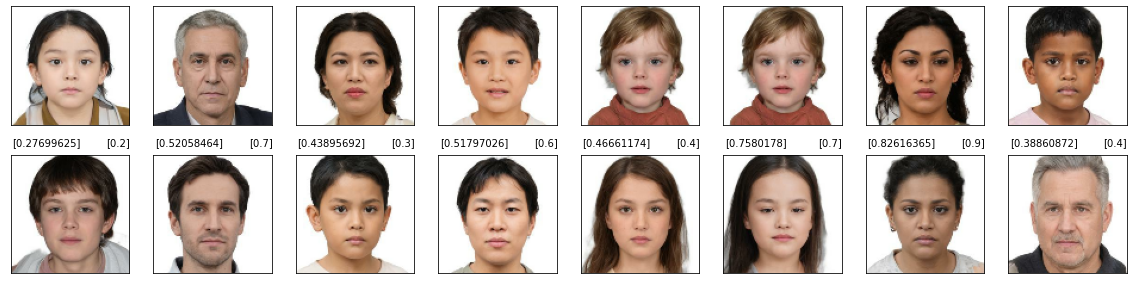

In [ ]:
plt.figure(figsize=(20,5))
for i in range(1,9):
  plt.subplot(2,8,i)
  plt.imshow(test_input[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(2,8,i+8)
  plt.imshow(test_val[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.text(1,-8,y_hat[i-1])
  plt.text(80,-8,y_true[i-1])
plt.show()


In [ ]:
siamese_model_trained = keras.models.load_model('siamesemodel_trained.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
y_hat_lfw = siamese_model_trained.predict([test_input, test_val])

1/1 [==============================] - 0s 141ms/step


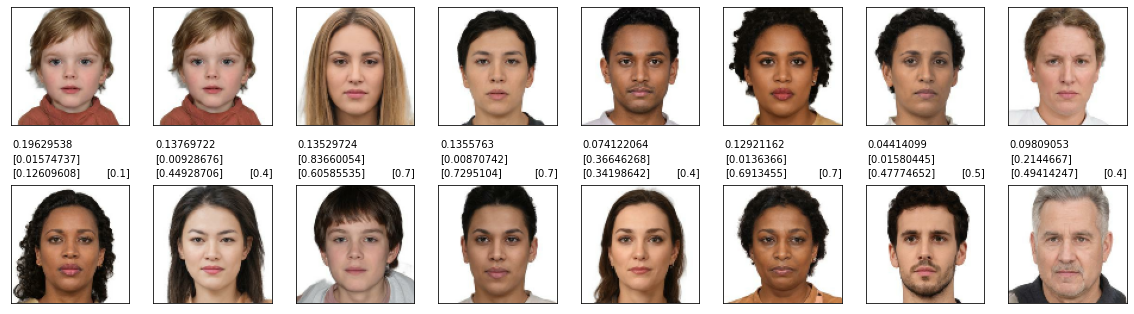

In [ ]:
plt.figure(figsize=(20,6))
for i in range(1,9):
  plt.subplot(2,8,i)
  plt.imshow(test_input[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(2,8,i+8)
  plt.imshow(test_val[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.text(1,-8,y_hat[i-1])
  plt.text(1,-20,y_hat_lfw[i-1])
  plt.text(1,-32,np.array(Dw)[i-1])
  plt.text(80,-8,y_true[i-1])

plt.show()

In [ ]:
GX1 = model(test_input, training=False)
GX2 = model(test_val, training=False)

_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

In [ ]:
Dw

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.19629538, 0.13769722, 0.13529724, 0.1355763 , 0.07412206,
       0.12921162, 0.04414099, 0.09809053, 0.2794216 , 0.49846408,
       0.3418445 , 0.41708708, 0.08540219, 0.13281842, 0.07228734,
       0.07651598], dtype=float32)>

In [ ]:
n = np.array(Dw)

In [ ]:
n

array([0.19629538, 0.13769722, 0.13529724, 0.1355763 , 0.07412206,
       0.12921162, 0.04414099, 0.09809053, 0.2794216 , 0.49846408,
       0.3418445 , 0.41708708, 0.08540219, 0.13281842, 0.07228734,
       0.07651598], dtype=float32)

In [ ]:
yhat = siamese_model.predict([np.array([test_input[1]]),np.array([test_input[1]])])

1/1 [==============================] - 0s 22ms/step


In [ ]:
yhat

array([[0.63156146]], dtype=float32)

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 7s 7s/step


In [ ]:
y_hat

array([[0.99999595],
       [0.9998975 ],
       [0.9995191 ],
       [0.99865204],
       [0.9999987 ],
       [0.9843627 ],
       [0.7921154 ],
       [1.        ],
       [0.9998128 ],
       [0.9995229 ],
       [0.9989563 ],
       [0.9999862 ],
       [0.9999982 ],
       [0.99359083],
       [0.99938   ],
       [0.92744005]], dtype=float32)

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
y_true

array([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()


1.0

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
r = Recall()
p = []

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.append(similarity_presicision(y_true, yhat))

print(r.result().numpy(), sum(p)/len(p))

In [ ]:
test_input

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

In [ ]:
# Save weights
siamese_model.save('siamesemodel_trained_by_lfw.h5')

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
test_input

In [ ]:
t1 = preprocess("./Aaron_Eckhart_0001.jpg")
t_arr = np.array([t1])

In [ ]:
t_arr

In [ ]:
tt = preprocess("./Aaron_Peirsol_0002.jpg")
yhat = siamese_model_try.predict([np.array([tt]),np.array([tt])])
print(yhat)

1/1 [==============================] - 0s 23ms/step
[[0.46294674]]


In [ ]:
t1 = preprocess("./geeks.jpg")
t12 = preprocess("./geeks125.jpg")
t21 = preprocess("./Aaron_Peirsol_0001.jpg")
t22 = preprocess("./Aaron_Peirsol_0002.jpg")
t3 = preprocess("./Aaron_Eckhart_0001.jpg")
t4 = preprocess("Aaron_Guiel_0001.jpg")

yhat = siamese_model.predict([np.array([t1]),np.array([t22])])
print(yhat)


1/1 [==============================] - 0s 23ms/step
[[0.00120359]]


In [ ]:
from PIL import Image

In [ ]:
screenshot = Image.open("./125.jpg")

In [ ]:
t1 = screenshot.convert('RGB')

In [ ]:
im = t1.save("geeks125.jpg")

In [ ]:
yhat1 = siamese_model_try.predict([np.array([t1]),np.array([t2])])
print(yhat1)

In [ ]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Test_facial similarity

In [ ]:
class Dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
work_dir = './tboard_logs'
model_id = 31911
#test_dataset_path = './test_v2.tfrecords'

checkpoint_dir = os.path.join(work_dir, str(model_id))

with open(checkpoint_dir + '/meta.json', 'r') as fp:
    training_args = Dotdict(json.load(fp))

In [ ]:
#DenseNet
l2 = tf.keras.regularizers.l2


class TransitionLayer(Model):
    def __init__(self, theta, depth, weight_decay, momentum=0.99, epsilon=0.001):
        super(TransitionLayer, self).__init__()
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=momentum, epsilon=epsilon)
        self.conv1 = tf.keras.layers.Conv2D(filters=int(theta * depth), use_bias=False, kernel_size=1, activation=None,
                                            kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay),
                                            strides=1, padding="same")

        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding="same")

    def call(self, inputs, training):
        net = self.bn1(inputs, training=training)
        net = tf.nn.relu(net)
        net = self.conv1(net)
        net = self.pool1(net)
        return net


class DenseUnit(Model):
    def __init__(self, k, weight_decay, momentum=0.99, epsilon=0.001):
        super(DenseUnit, self).__init__()

        self.bn1 = tf.keras.layers.BatchNormalization(momentum=momentum, epsilon=epsilon)
        self.conv1 = tf.keras.layers.Conv2D(filters=4 * k, use_bias=False, kernel_size=1, strides=1,
                                            padding="same", name="unit_conv", activation=None,
                                            kernel_initializer="he_normal", kernel_regularizer=l2(weight_decay))

        self.bn2 = tf.keras.layers.BatchNormalization(momentum=momentum, epsilon=epsilon)
        self.conv2 = tf.keras.layers.Conv2D(filters=k, use_bias=False, kernel_size=3, strides=1, padding="same",
                                            activation=None, kernel_initializer="he_normal",
                                            kernel_regularizer=l2(weight_decay))

    def call(self, inputs, training):
        net = self.bn1(inputs, training=training)
        net = tf.nn.relu(net)
        net = self.conv1(net)
        net = self.bn2(net, training=training)
        net = tf.nn.relu(net)
        net = self.conv2(net)
        return net


class DenseBlock(Model):
    def __init__(self, k, weight_decay, number_of_units, momentum=0.99, epsilon=0.001):
        super(DenseBlock, self).__init__()
        self.number_of_units = number_of_units
        self.units = self._add_cells([DenseUnit(k, weight_decay=weight_decay, momentum=momentum, epsilon=epsilon) for i in range(number_of_units)])

    def _add_cells(self, cells):
        # "Magic" required for keras.Model classes to track all the variables in
        # a list of layers.Layer objects.
        for i, c in enumerate(cells):
            setattr(self, "cell-%d" % i, c)
        return cells

    def call(self, x, training):
        x = self.units[0](x, training=training)
        for i in range(1, int(self.number_of_units)):
            output = self.units[i](x, training=training)
            x = tf.concat([x, output], axis=3)

        return x


class DenseNet(Model):
    def __init__(self, k, units_per_block, weight_decay=1e-4, num_outputs=10, theta=1.0, momentum=0.99, epsilon=0.001,
                 initial_pool=True):
        super(DenseNet, self).__init__()
        self.initial_pool = initial_pool
        # The initial convolution layer comprises 2k convolutions of size 7×7 with stride 2;
        self.conv1 = tf.keras.layers.Conv2D(filters=2 * k, kernel_size=7, strides=2, padding="same",
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=l2(weight_decay))

        if self.initial_pool:
            self.pool1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="same")

        self.number_of_blocks = len(units_per_block)
        self.dense_blocks = self._add_cells([DenseBlock(k=k, number_of_units=units_per_block[i], weight_decay=weight_decay,
                               momentum=momentum, epsilon=epsilon) for i in range(self.number_of_blocks)])

        self.transition_layers = self._add_cells([TransitionLayer(theta=theta, depth=k * units_per_block[i], weight_decay=weight_decay,
                                        momentum=momentum, epsilon=epsilon) for i in range(self.number_of_blocks-1)])

        self.glo_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.logits = tf.keras.layers.Dense(units=num_outputs)

    def _add_cells(self, cells):
        # "Magic" required for keras.Model classes to track all the variables in
        # a list of layers.Layer objects.
        for i, c in enumerate(cells):
            setattr(self, "cell-%d" % i, c)
        return cells


    def call(self, input, training):
        """Run the model."""
        net = self.conv1(input)

        if self.initial_pool:
            net = self.pool1(net)

        for block, transition in zip(self.dense_blocks[:-1], self.transition_layers):
            net = block(net, training=training)
            net = transition(net, training=training)

        net = self.dense_blocks[-1](net, training=training)
        net = self.glo_avg_pool(net)

        return self.logits(net)

In [ ]:
args = {"k": training_args.growth_rate,
        "weight_decay": training_args.l2_regularization,
        "num_outputs": training_args.num_outputs,
        "units_per_block": training_args.units_per_block,
        "momentum": training_args.momentum,
        "epsilon": training_args.epsilon,
        "initial_pool": training_args.initial_pool}

model = DenseNet(**args)
optimz = tf.keras.optimizers.Adam(1e-4)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(model=model,step= tf.Variable(1),optimizer=optimz)
manager = tf.train.CheckpointManager(root,"./ckpt",max_to_keep=3)

try:
    #root.restore(tf.train.latest_checkpoint(checkpoint_dir))
    root.restore(manager.latest_checkpoint)
    print("Model {} successfully loaded.".format(model_id))
except:
    print("Error loading model: {}".format(FLAGS.model_id))

Model 31911 successfully loaded.


In [ ]:
# preprocess functions
def apply_random_transformations(image, number_of_transformations=2):
    # randomly select two image transformations
    np.random.shuffle(transformations)

    for i in range(number_of_transformations):
        if np.random.random_sample() > 0.5:
            image = transformations[i](image)

    return image

def random_hue(image):
    return tf.image.random_hue(image, max_delta=0.1)

def random_saturation(image):
    return tf.image.random_saturation(image, lower=0.5, upper=1.5)

def random_contrast(image):
    return tf.image.random_contrast(image, lower=0.5, upper=1.5)

def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=32. / 255.)

transformations = np.array([random_contrast, random_brightness, random_saturation, random_hue])

def tf_record_parser(record, to_grayscale=False):
    keys_to_features = {
        "Xi": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'Xj': tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature((), tf.int64),
        "height": tf.io.FixedLenFeature((), tf.int64),
        "width": tf.io.FixedLenFeature((), tf.int64)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    Xi = tf.io.decode_raw(features['Xi'], tf.uint8)
    Xj = tf.io.decode_raw(features['Xj'], tf.uint8)

    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    # reshape input and annotation images
    Xi = tf.reshape(Xi, (height, width, 3), name="image_reshape")
    Xj = tf.reshape(Xj, (height, width, 3), name="annotation_reshape")

    if to_grayscale:
        Xi = tf.image.rgb_to_grayscale(Xi)
        Xj = tf.image.rgb_to_grayscale(Xj)

    return tf.cast(Xi,tf.float64) / 255., tf.cast(Xj,tf.float32) / 255., label


def random_resize_and_crop(Xi, Xj, label, crop_size=128):
    input_shape = tf.shape(Xi)[0:2]
    n_channels = tf.shape(Xi)[-1]
    input_shape_float = tf.cast(input_shape,tf.float32)

    scale = tf.random.uniform(shape=[1],
                              minval=0.9,
                              maxval=1.1)

    scaled_shape = tf.cast(tf.round(input_shape_float * scale),tf.int32)

    Xi = tf.image.resize(Xi, scaled_shape,
                                method=tf.image.ResizeMethod.BILINEAR)

    Xj = tf.image.resize(Xj, scaled_shape,
                                method=tf.image.ResizeMethod.BILINEAR)

    Xi = tf.image.random_crop(Xi, (crop_size, crop_size, n_channels))
    Xj = tf.image.random_crop(Xj, (crop_size, crop_size, n_channels))
    return Xi, Xj, label


def random_image_rotation(Xi, Xj, label):
    rotation = tf.random.uniform(shape=[1],
                                 minval=-0.2,
                                 maxval=0.2)
    Xi = tfa.image.rotate(Xi, rotation, interpolation='NEAREST')
    Xj = tfa.image.rotate(Xj, rotation, interpolation='NEAREST')

    return Xi, Xj, label

def random_distortions(Xi, Xj, label):
    Xi = tf.clip_by_value(tf.py_function(apply_random_transformations, [Xi], tf.float32), 0.0, 1.0)
    Xj = tf.clip_by_value(tf.py_function(apply_random_transformations, [Xj], tf.float32), 0.0, 1.0)
    return Xi, Xj, label

def random_flip_left_right(Xi, Xj, label):
    Xi = tf.image.random_flip_left_right(Xi)
    Xj = tf.image.random_flip_left_right(Xj)
    return Xi, Xj, label


def normalizer(Xi, Xj, label):
    Xi = tf.subtract(Xi, 0.5)
    Xi = tf.multiply(Xi, 2.0)

    Xj = tf.subtract(Xj, 0.5)
    Xj = tf.multiply(Xj, 2.0)
    return Xi, Xj, label

def central_image_crop(Xi, Xj, label, crop_size=128):
    return tf.image.resize_with_crop_or_pad(Xi, target_height=crop_size, target_width=crop_size), \
           tf.image.resize_with_crop_or_pad(Xj, target_height=crop_size, target_width=crop_size), \
           label

def denormalize(image):
    return tf.add(tf.divide(image, 2), 0.5)

In [ ]:
def contrastive_loss(logits1, logits2, label, margin, eps=1e-7):
    Dw = tf.sqrt(eps + tf.reduce_sum(tf.square(logits1 - logits2), 1))
    loss = tf.reduce_mean((1. - tf.cast(label,dtype=tf.float32)) * tf.square(Dw) + tf.cast(label,dtype=tf.float32) * tf.math.square(tf.maximum(margin - Dw, 0)))
    return loss, Dw

In [ ]:
test_dataset_path = './test_v2.tfrecords'
test_filenames = [test_dataset_path]
test_dataset = tf.data.TFRecordDataset(test_filenames)
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.map(random_resize_and_crop)
test_dataset = test_dataset.map(normalizer)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(16)

In [ ]:
test_input, test_val, y_true = test_dataset.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat_lfw = siamese_model_trained.predict([test_input, test_val])
GX1 = model(test_input, training=False)
GX2 = model(test_val, training=False)
_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

1/1 [==============================] - 0s 22ms/step


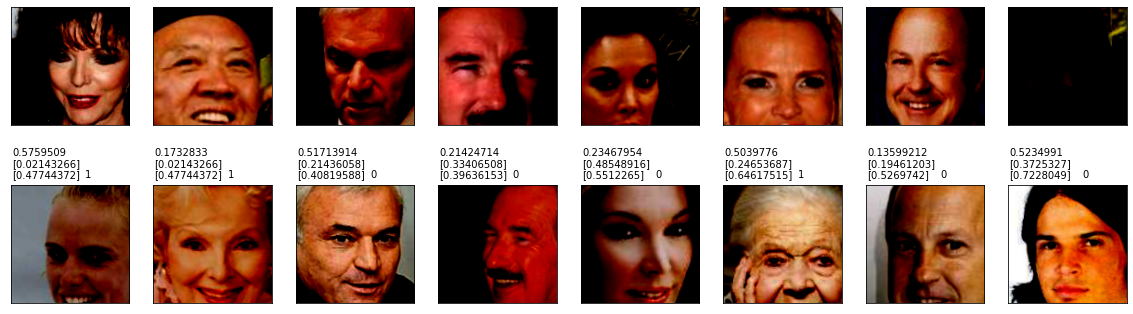

In [ ]:
plt.figure(figsize=(20,6))

for i in range(1,9):
  plt.subplot(2,8,i)
  plt.imshow(test_input[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(2,8,i+8)
  plt.imshow(test_val[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.text(1,-8,y_hat[i-1])
  plt.text(1,-20,y_hat_lfw[i-1])
  plt.text(1,-32,np.array(Dw)[i-1])
  plt.text(80,-8,y_true[i-1])

plt.show()

In [ ]:
test_input, test_val, y_true = test_data_lfw.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat_lfw = siamese_model_trained.predict([test_input, test_val])
GX1 = model(test_input, training=False)
GX2 = model(test_val, training=False)
_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

1/1 [==============================] - 0s 25ms/step


In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_dataset.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

FailedPreconditionError: ignored

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


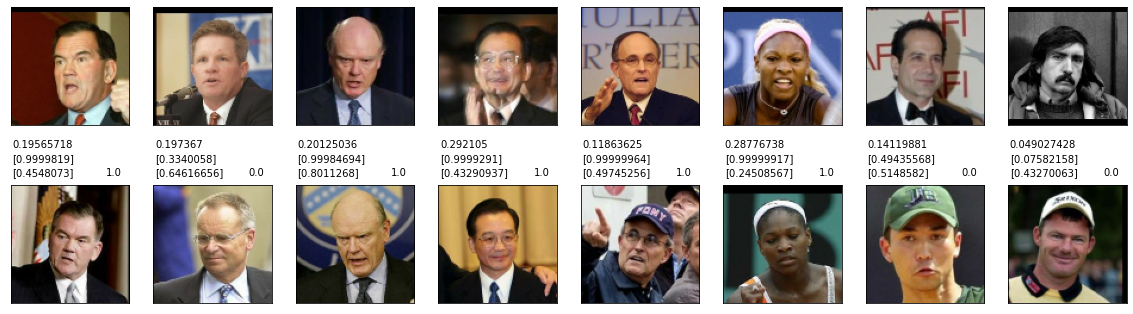

In [ ]:
plt.figure(figsize=(20,6))

for i in range(1,9):
  plt.subplot(2,8,i)
  plt.imshow(test_input[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplot(2,8,i+8)
  plt.imshow(test_val[i-1])
  plt.xticks([])
  plt.yticks([])
  plt.text(1,-8,y_hat[i-1])
  plt.text(1,-20,y_hat_lfw[i-1])
  plt.text(1,-32,np.array(Dw)[i-1])
  plt.text(80,-8,y_true[i-1])

plt.show()

# New Section

In [ ]:
from PIL import Image

In [ ]:
for directory in os.listdir("test_gen"):
  name = directory[:-4]
  print(name)
  Image.open("test_gen/"+directory).convert('RGB').save("./testdata_gen/"+name+".jpg")

In [ ]:
a = np.array(test_input)

In [ ]:
a

array([b'test_gen/v3_0350227.jpg', b'test_gen/v3_0350227.jpg',
       b'test_gen/v3_0420615.jpg', b'test_gen/v3_0641511.jpg',
       b'test_gen/v3_0261957.jpg', b'test_gen/v3_0355575.jpg',
       b'test_gen/v3_0845686.jpg', b'test_gen/v3_0602577.jpg',
       b'test_gen/v3_0854798.jpg', b'test_gen/v3_0926219.jpg',
       b'test_gen/v3_0687065.jpg'], dtype=object)

In [ ]:
test_input, test_val, y_true = testdataset_gen.as_numpy_iterator().next()
GX1 = model(test_input, training=False)
GX2 = model(test_val, training=False)

_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

In [ ]:
Dw

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([3.1622776e-04, 3.1622776e-04, 2.8202122e-01, 3.1622776e-04,
       8.8454887e-02, 3.1622776e-04, 5.7845300e-01, 3.1622776e-04,
       1.7955001e-01, 3.1622776e-04, 8.5329592e-02], dtype=float32)>

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
GX1 = model(test_input, training=False)
GX2 = model(test_input, training=False)

_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

In [ ]:
Dw[1].numpy()

0.00031622776

In [ ]:
Dw

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.00031623, 0.00031623, 0.00031623, 0.00031623, 0.00031623,
       0.00031623, 0.00031623, 0.00031623, 0.00031623, 0.00031623,
       0.00031623, 0.00031623, 0.00031623, 0.00031623, 0.00031623,
       0.00031623], dtype=float32)>

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
GX1 = model(test_input, training=False)
GX2 = model(test_val, training=False)

_, Dw = contrastive_loss(GX1, GX2, y_true, margin=2.)

In [ ]:
Dw

<tf.Tensor: shape=(16,), dtype=float32, numpy=
array([0.24913245, 0.26308715, 0.6967272 , 0.87774414, 0.79119474,
       0.8001192 , 0.14847271, 0.15161619, 0.88515675, 0.23376714,
       0.4190336 , 0.4148885 , 0.3212396 , 0.64553154, 0.42924705,
       1.2606436 ], dtype=float32)>

In [ ]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

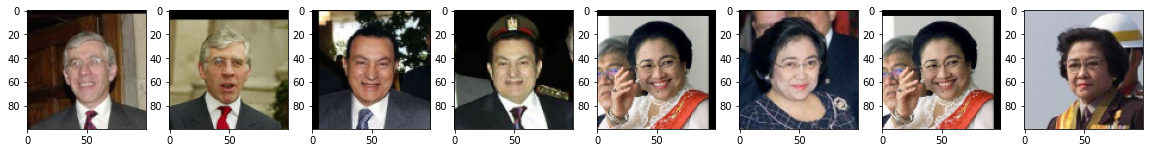

In [ ]:
plt.figure(figsize=(20,16))

# Set first subplot
plt.subplot(1,8,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,8,2)
plt.imshow(test_val[0])

plt.subplot(1,8,3)
plt.imshow(test_input[1])

plt.subplot(1,8,4)
plt.imshow(test_val[1])

plt.subplot(1,8,5)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,8,6)
plt.imshow(test_val[2])

plt.subplot(1,8,7)
plt.imshow(test_input[3])

plt.subplot(1,8,8)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [ ]:
y = np.array([0.3279467680608365,
 0.3296102661596958,
 0.3438688212927757,
 0.34600760456273766,
 0.3676330798479088,
 0.37951520912547526,
 0.3828422053231939,
 0.3902091254752852,
 0.37119771863117873,
 0.3600285171102662,
 0.3602661596958175,
 0.3821292775665399,
 0.4082699619771863,
 0.406606463878327,
 0.4251425855513308,
 0.42490494296577946,
 0.4284695817490494,
 0.44843155893536124,
 0.44724334600760457,
 0.4519961977186312,
 0.46506653992395436,
 0.4524714828897338,
 0.47029467680608367,
 0.48170152091254753,
 0.48978136882129275,
 0.500712927756654,
 0.5171102661596958,
 0.5171102661596958,
 0.5135456273764258,
 0.5192490494296578,
 0.5313688212927756,
 0.5434885931558935,
 0.5601235741444867,
 0.561787072243346,
 0.5701045627376425,
 0.5627376425855514,
 0.5798479087452472,
 0.5857889733840305,
 0.5691539923954373,
 0.5829372623574145,
 0.6000475285171103,
 0.5971958174904943,
 0.5986216730038023,
 0.6067015209125475,
 0.5981463878326996,
 0.6185836501901141,
 0.6192965779467681,
 0.6309410646387833,
 0.6074144486692015,
 0.6425855513307985])